In [1]:
import h5py
import tangos as db
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# How to read in file that contains data on every star that is in Tempest's stellar halo at z=0
f = h5py.File('/Users/bnguyen/Downloads/Tempest_RD0042_allhalostardata.h5','r')
pids = f['particle_IDs'][:] # particle index of star - constant across simulation (int)
ptind = f['timestep_location'][:] # index of timestep at which star formed (int; 0->DD0044)
hids = f['host_IDs'].asstr()[:] # unique ID of halo in which star forms (string, constant across simulation)
pp = f['particle_positions'][:] # location at which star forms ([x,y,z], float, Mpc)
ct = f['particle_creation_times'][:] # time at which star was formed (float, Gyr)
ph = f['particle_hosts'][:] # halo number of halo in which star forms (int, holds only for timestep)
f.close()
# Note: some star particles form before our first saved timestep or in halos that our halo finder has lost track of.
# The vast majority can still be reliably assigned to a halo via other methods and therefore have a 'host_IDs' value.
# However, they may have 0s or -1s for 'timestep_location' and/or 'particle_hosts'.
# The 'host_IDs' value is the most important means of grouping halo stars. Star particles that formed in the same halo
# at different timesteps will have different 'timestep_locations' values and possibly different 'particle_hosts' values,
# but they will have the same 'host_IDs' value. The 'host_IDs' value can be understood as follows:
#   The number before the underscore is the timestep at which the star-forming halo was last distinguished by the halo
#   finder as an independent halo, either before it merged with another, more massive halo or before it lost too many
#   particles to be tracked.
#   The number after the underscore is the halo number of the halo at this timestep.
#   So, for example, a 'host_IDs' value of '1878_101' means that this star formed in a halo that is last 
#   distinguished at timestep DD1878 and has halo_number = 101 at this timestep. A star with 'host_IDs'='2427_1'
#   formed inside of Tempest itself.

In [3]:
allhosts = np.unique(hids)
allhosts = allhosts[allhosts != '']
allhosts = allhosts[allhosts != '2427_1'] # This excludes Tempest itself, whose host ID is '2427_1'

print ('Tempest has '+str(len(allhosts))+' independent halos that contribute to its stellar halo.')
print ('These are:',allhosts[:])

Tempest has 49 independent halos that contribute to its stellar halo.
These are: ['0113_6' '0142_77' '0152_77' '0153_75' '0154_40' '0190_55' '0199_30'
 '0200_22' '0208_111' '0216_75' '0299_171' '0310_12' '0312_251' '0323_33'
 '0324_14' '0326_1' '0326_2' '0373_57' '0377_65' '0386_39' '0395_35'
 '0397_46' '0398_24' '0400_62' '0409_28' '0410_28' '0416_51' '0419_83'
 '0427_16' '0448_94' '0468_7' '0520_296' '0570_6' '0627_4' '0641_51'
 '0745_57' '0786_3' '0840_159' '0946_68' '0994_85' '1057_92' '1092_39'
 '1233_7' '1487_28' '1645_5' '1649_6' '1779_14' '1878_101' '2427_51']


In [4]:
time_index = np.zeros(len(allhosts))
halo_number = np.zeros(len(allhosts))

i = 0
for s in allhosts:
    string = s.split('_')
    time_index[i] = int(string[0])
    halo_number[i] = string[1]
    i += 1
    
# we also have to subtract by 44 because that's the first timestep
time_index = time_index.astype(int) - 44 

In [5]:
print(time_index)
print(type(time_index[2]))

[  69   98  108  109  110  146  155  156  164  172  255  266  268  279
  280  282  282  329  333  342  351  353  354  356  365  366  372  375
  383  404  424  476  526  583  597  701  742  796  902  950 1013 1048
 1189 1443 1601 1605 1735 1834 2383]
<class 'numpy.int64'>


In [6]:
db.all_simulations()

[<Simulation("Tempest.9f11c.all.DD")>]

In [7]:
sim = db.get_simulation('Tempest.9f11c.all.DD')

In [8]:
'''This finds the time at which each halo starts contributing (a.k.a. getting stripped) to Tempest.'''

halo_time = np.zeros(len(allhosts))
i = 0
for index in time_index:
    halo_time[i] = sim[int(index)].time_gyr
    i += 1
    
print(halo_time)

[ 1.31938417  1.47538672  1.52918071  1.53456011  1.53993951  1.73359786
  1.78201244  1.78739184  1.83042703  1.87346222  2.3199523   2.37912568
  2.38988448  2.44905786  2.45443726  2.46519606  2.46519606  2.71802779
  2.73954539  2.78795997  2.83637456  2.84713336  2.85251276  2.86327155
  2.91168614  2.91706554  2.94934193  2.9654798   3.00851532  3.12148269
  3.22907066  3.50879938  3.77776931  4.08439503  4.15970661  4.71916406
  4.9397194   5.23020692  5.80042317  6.0532549   6.39215701  6.58043596
  7.33893116  8.70529839  9.55524337  9.57676096 10.27608277 10.80864323
 13.75931383]


In [9]:
i = 0

all_sat_t = []
all_sat_idx = []

all_sat_r = []
all_sat_ratio = []

all_sat_rvir = []
all_sat_mvir = []
all_sat_mvir_ratio = []
all_sat_mvir_max = []

all_host_rvir = []
all_host_mvir = []

while i < np.size(halo_number):
    sat_idx = int(halo_number[i])
    time_idx = int(time_index[i])
            
    if isinstance(sim[time_idx][sat_idx], type(None)) is False:
        # this uses pre-coded tangos stuff to get M_vir and distance measurements at all available redshifts
        host_rvir, host_mvir, host_x, host_y, host_z, host_t = \
                        sim[time_idx][1].calculate_for_progenitors('Rvir', 'Mvir', 'X', 'Y', 'Z', 't()')
        sat_rvir, sat_mvir, sat_x, sat_y, sat_z, sat_t = \
                        sim[time_idx][sat_idx].calculate_for_progenitors('Rvir', 'Mvir', 'X', 'Y', 'Z', 't()')

        # now, we have to correct for the distance of the satellite halos from the host halo, which itself
        # is also moving. to do this, we need to subtract the position of the satellite by the position of
        # the host. 
        # because the host halo and satellite halos might not be observed at the exact same amount of redshifts,
        # we first need to exclude the non-overlapping redshifts so that it's easier to subtract

        ### this checks for non-overlapping redshifts between host and satellite. 
        ### if non-overlapping, then array element set to 0
        for j in range(np.size(host_t)):
            if host_t[j] not in sat_t: 
                host_t[j] = 0.
                host_x[j] = 0.
                host_y[j] = 0.
                host_z[j] = 0.
                host_rvir[j] = 0.
                host_mvir[j] = 0.

        ### this checks for non-overlapping redshifts between satellite and host. 
        ### if non-overlapping, then array element set to 0
        for k in range(np.size(sat_t)):
            if sat_t[k] not in host_t:
                sat_t[k] = 0.
                sat_x[k] = 0.
                sat_y[k] = 0.
                sat_z[k] = 0.
                sat_rvir[k] = 0.
                sat_mvir[k] = 0.

        ### this removes all the zeros
        host_t = host_t[host_t != 0.]
        host_x = host_x[host_x != 0.]
        host_y = host_y[host_y != 0.]
        host_z = host_z[host_z != 0.]
        host_rvir = host_rvir[host_rvir != 0.]
        host_mvir = host_mvir[host_mvir != 0.]
        sat_t = sat_t[sat_t != 0.]
        sat_x = sat_x[sat_x != 0.]
        sat_y = sat_y[sat_y != 0.]
        sat_z = sat_z[sat_z != 0.]
        sat_rvir = sat_rvir[sat_rvir != 0.]
        sat_mvir = sat_mvir[sat_mvir != 0.]

        # here comes the actual subtracting correction
        sat_x = sat_x - host_x
        sat_y = sat_y - host_y
        sat_z = sat_z - host_z

        # finally, we get the 3D distance and scale it by the virial radius of the host halo (Tempest)
        sat_r = np.sqrt(sat_x**2 + sat_y**2 + sat_z**2)

        # this plots distance vs. time for each halo with regard to their host halo
        mass_ratio = sat_mvir / max(sat_mvir)
        
        all_sat_t.append(sat_t)
        
        all_sat_r.append(sat_r * 1000) # multiply by 1000 so that the positions are in kpc like the virial radii
        all_sat_ratio.append(sat_r * 1000 / host_rvir)
        
        all_sat_rvir.append(sat_rvir)
        all_sat_mvir.append(sat_mvir)
        all_sat_mvir_ratio.append(mass_ratio)
        all_sat_mvir_max.append(max(sat_mvir))
        
        all_host_rvir.append(host_rvir)
        all_host_mvir.append(host_mvir)
        
        all_sat_idx.append([time_idx, sat_idx])
        
        print(sat_idx, time_idx)
            
    i += 1
    
all_sat_t = np.array(all_sat_t, dtype='object') #unit: Gyr
all_sat_r = np.array(all_sat_r, dtype='object') #unit: kpc
all_sat_ratio = np.array(all_sat_ratio, dtype='object') #unitless

all_sat_rvir = np.array(all_sat_rvir, dtype='object') #unit: kpc
all_sat_mvir_max = np.array(all_sat_mvir_max, dtype='object') #unit: Msun
all_sat_mvir = np.array(all_sat_mvir, dtype='object') #unit: Msun

all_host_rvir = np.array(all_host_rvir, dtype='object') #unit: kpc
all_host_mvir = np.array(all_host_mvir, dtype='object') #unit: Msun

all_sat_idx = np.array(all_sat_idx, dtype='object')

print('success!')

6 69
77 98
77 108
75 109
40 110
55 146
30 155
22 156
111 164
75 172
171 255
12 266
251 268
33 279
14 280
1 282
2 282
57 329
65 333
39 342
35 351
46 353
24 354
62 356
28 365
28 366
51 372
83 375
16 383
94 404
7 424
296 476
6 526
4 583
51 597
57 701
3 742
159 796
68 902
85 950
92 1013
39 1048
7 1189
28 1443
5 1601
6 1605
14 1735
101 1834
51 2383
success!


In [10]:
# this is just to generate the same colors for both plots

r_array = []
b_array = []
g_array = []

for i in range(np.size(all_sat_t)):
    r = random.random()
    b = random.random()
    g = random.random()
    r_array.append(r)
    b_array.append(b)
    g_array.append(g)
    
r_array = np.array(r_array)
b_array = np.array(b_array)
g_array = np.array(g_array)

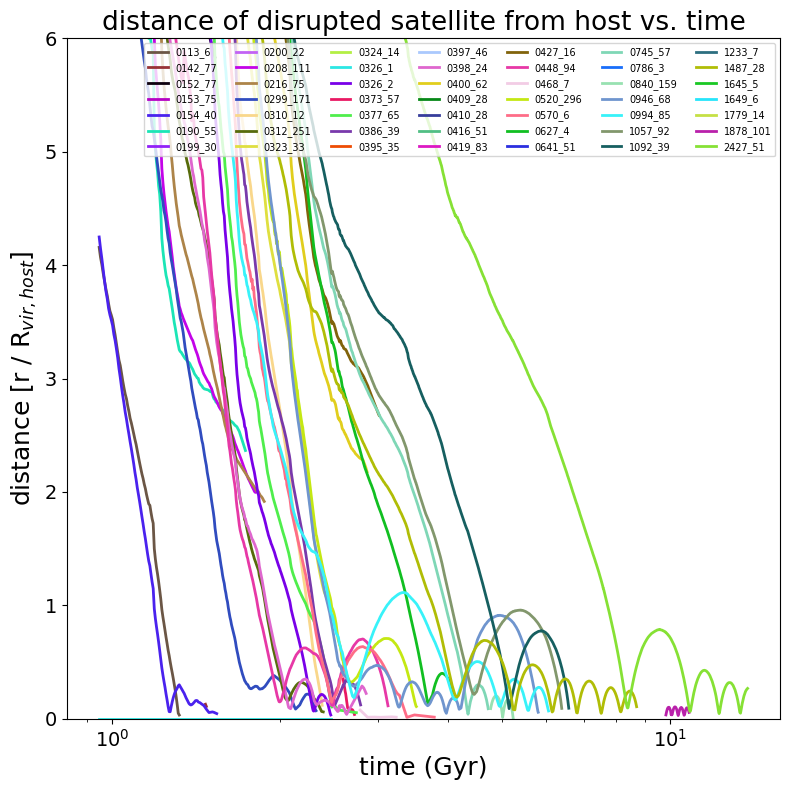

In [16]:
fig, ax = plt.subplots(figsize=(8,8))

for i in range(np.size(all_sat_t)):
    plt.plot(all_sat_t[i], all_sat_ratio[i], linewidth=2, c=(r_array[i], b_array[i], g_array[i]), \
            label=allhosts[i])
    
plt.legend(loc='upper right', prop={'size': 7}, ncol=7)
plt.title('distance of disrupted satellite from host vs. time', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('distance [r / R$_{vir,host}$]', fontsize=18)
plt.yticks(fontsize=14)
plt.ylim(0, 6)
plt.xscale('log')
plt.tight_layout()
plt.style.use('default')
plt.savefig('plots/disrupted_sat_distance_over_time.png')

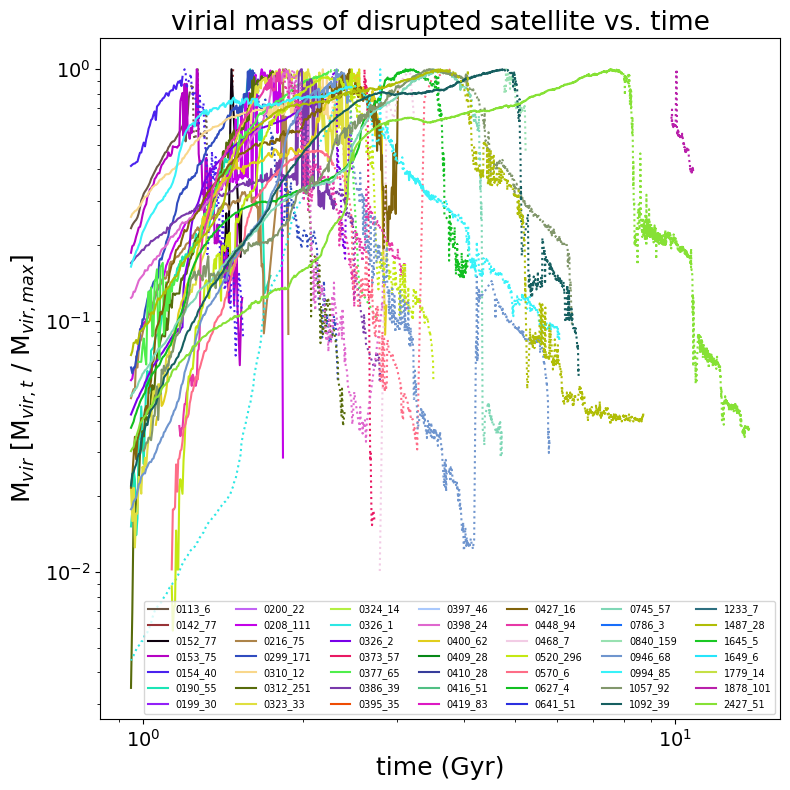

In [12]:
fig, ax = plt.subplots(figsize=(8,8))

for i in range(np.size(all_sat_t)):
    radius_ratio = all_sat_r[i] / all_host_rvir[i]
    in_rvir = radius_ratio <= 1
    out_rvir = radius_ratio > 1
    plt.plot(all_sat_t[i], np.ma.masked_where(in_rvir, all_sat_mvir_ratio[i]), linestyle='-', \
             c=(r_array[i], b_array[i], g_array[i]), label=allhosts[i])
    plt.plot(all_sat_t[i], np.ma.masked_where(out_rvir, all_sat_mvir_ratio[i]), linestyle=':', \
             c=(r_array[i], b_array[i], g_array[i]))
    
plt.legend(loc='lower right', prop={'size': 7}, ncol=7)
plt.title('virial mass of disrupted satellite vs. time', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('M$_{vir}$ [M$_{vir,t}$ / M$_{vir,max}$]', fontsize=18)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.style.use('default')
plt.savefig('plots/disrupted_sat_mvir_over_time.png')

In [13]:
"""
Next, we investigate if any of the satellites have their peak Mvir
at the first time of appearance in the simulation.
"""

first_time_peak_idx = []
how_many_peaks = 0

for i in range(np.size(all_sat_mvir)):
    if all_sat_mvir[i][0] == max(all_sat_mvir[i]):
        how_many_peaks += 1
        first_time_peak_idx.append(i)

In [14]:
"""
Here, we'll try to find out the time of first in-fall
and the peak Mvir of each of the satellite halos
"""

first_infall = np.zeros(np.size(all_sat_t))

for i in range(np.size(all_sat_t)):
    each_halo = all_sat_t[i]
    radius_ratio = all_sat_r[i] / all_host_rvir[i]
    infalls = each_halo[radius_ratio <= 1]
    if np.size(infalls) == 0:
        first_infall[i] = 0
    else:
        first_infall[i] = min(infalls)
        
with open("saved_data/Mvir_vs_1st_infall_disrupted.txt", "w") as f:
    for idx in range(np.size(all_sat_t)):
        if idx in first_time_peak_idx:
            f.write(str(first_infall[idx]) + ' ' + str(all_sat_mvir_max[idx]) + ' ' + str(1))
            f.write('\n')
        else:
            f.write(str(first_infall[idx]) + ' ' + str(all_sat_mvir_max[idx]) + ' ' + str(0))
            f.write('\n')
        
f.close()

In [18]:
disr = np.genfromtxt('saved_data/Mvir_vs_1st_infall_disrupted.txt', dtype='str')
disr_infall_time = np.array(disr[:,0], dtype='float32')
disr_max_mvir = np.array(disr[:,1], dtype='float32')
disr_peak = np.array(disr[:,2], dtype='float32')

surv = np.genfromtxt('saved_data/Mvir_vs_1st_infall_surviving.txt', dtype='str')
surv_infall_time = np.array(surv[:,0], dtype='float32')
surv_max_mvir = np.array(surv[:,1], dtype='float32')
surv_peak = np.array(surv[:,2], dtype='float32')

surv_stars = np.genfromtxt('saved_data/Mvir_vs_1st_infall_star_surviving.txt', dtype='str')
surv_stars_infall_time = np.array(surv_stars[:,0], dtype='float32')
surv_stars_max_mvir = np.array(surv_stars[:,1], dtype='float32')
surv_stars_peak = np.array(surv_stars[:,2], dtype='float32')

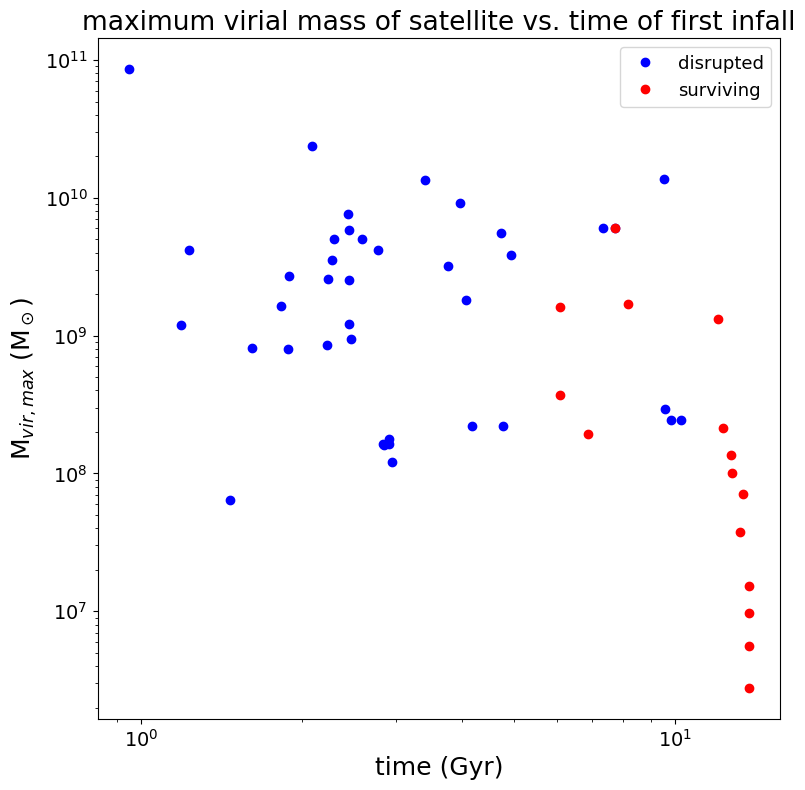

In [19]:
fig, ax = plt.subplots(figsize=(8,8))

plt.plot(disr_infall_time, disr_max_mvir, 'o', color='blue', \
         alpha=1, label='disrupted')
#plt.plot(surv_stars_infall_time, surv_stars_max_mvir, 'o', color='magenta', markersize=10, \
#         alpha=1, label='surviving, star-forming')
plt.plot(surv_infall_time, surv_max_mvir, 'o', color='red', \
         alpha=1, label='surviving')
    
plt.legend(loc='upper right', prop={'size': 13})
plt.title('maximum virial mass of satellite vs. time of first infall', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('M$_{vir,max}$ (M$_\odot$)', fontsize=18)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.style.use('default')
plt.savefig('plots/mvirmax_vs_first_infall.png')

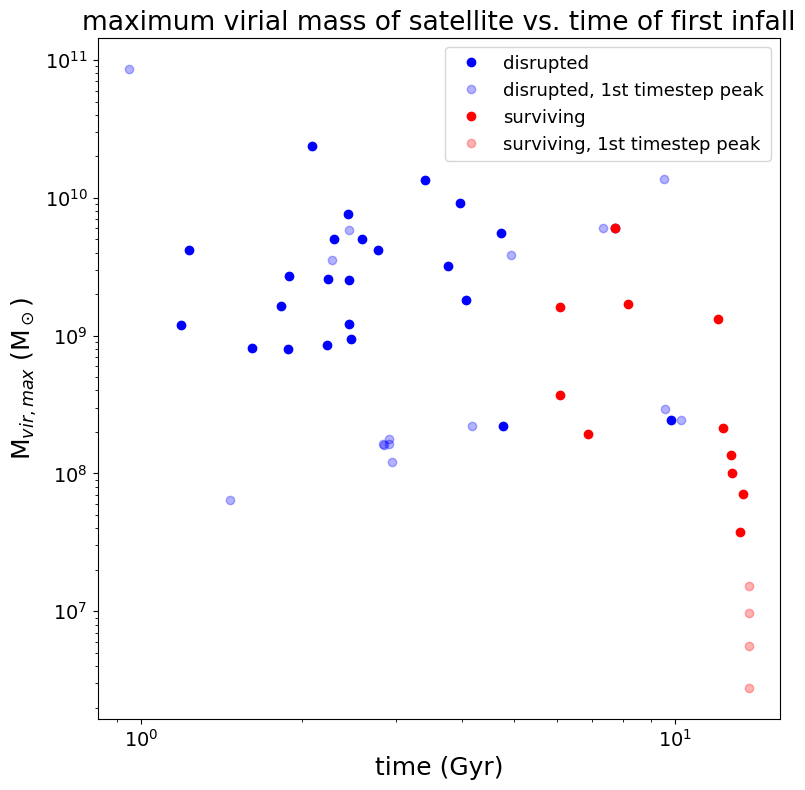

In [20]:
fig, ax = plt.subplots(figsize=(8,8))

plt.plot(disr_infall_time[disr_peak == 0], disr_max_mvir[disr_peak == 0], 'o', color='blue', \
         alpha=1.0, label='disrupted')
plt.plot(disr_infall_time[disr_peak == 1], disr_max_mvir[disr_peak == 1], 'o', color='blue', \
         alpha=0.3, label='disrupted, 1st timestep peak')

#plt.plot(surv_stars_infall_time, surv_stars_max_mvir, 'o', color='magenta', markersize=10, \
#         alpha=1, label='surviving, star-forming')
plt.plot(surv_infall_time[surv_peak == 0], surv_max_mvir[surv_peak == 0], 'o', color='red', \
         alpha=1.0, label='surviving')
plt.plot(surv_infall_time[surv_peak == 1], surv_max_mvir[surv_peak == 1], 'o', color='red', \
         alpha=0.3, label='surviving, 1st timestep peak')
    
plt.legend(loc='upper right', prop={'size': 13})
plt.title('maximum virial mass of satellite vs. time of first infall', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('M$_{vir,max}$ (M$_\odot$)', fontsize=18)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.style.use('default')
plt.savefig('plots/mvirmax_vs_first_infall_1st_peak.png')

Next, we calculate the tidal force that each satellite experiences over time. The tidal force is as follows:

$$
F = \frac{2GM_{vir}mr_{vir}}{d^3}
$$

where $G$ is the gravitational constant in relevant units; $M_{vir}$ is the virial mass of the host halo; $m$ is the virial mass of the satellite halo over time; $r_{vir}$ is the virial radius of the satellite halo; $d$ is the distance between the satellite halo and the host halo.

In [21]:
G = 4.30091e-3 # unit: pc (km/s)^2 / Msun

all_sat_Ftide = []

for i in range(np.size(all_sat_t)):
    M = all_host_mvir[i] # unit: Msun
    m = all_sat_mvir[i] # unit: Msun
    rvir = all_sat_rvir[i] * 1000 # converting kpc to pc
    d = all_sat_r[i] * 1000 # converting kpc to pc
    F = 2*G*M*m*rvir / (d**3)
    all_sat_Ftide.append(F)
    
all_sat_Ftide = np.array(all_sat_Ftide, dtype='object')

/var/folders/h4/tgpyd_z951x_9bzqftct7zxc00057b/T/ipykernel_91628/2927093037.py:10: RuntimeWarning: divide by zero encountered in true_divide
  F = 2*G*M*m*rvir / (d**3)


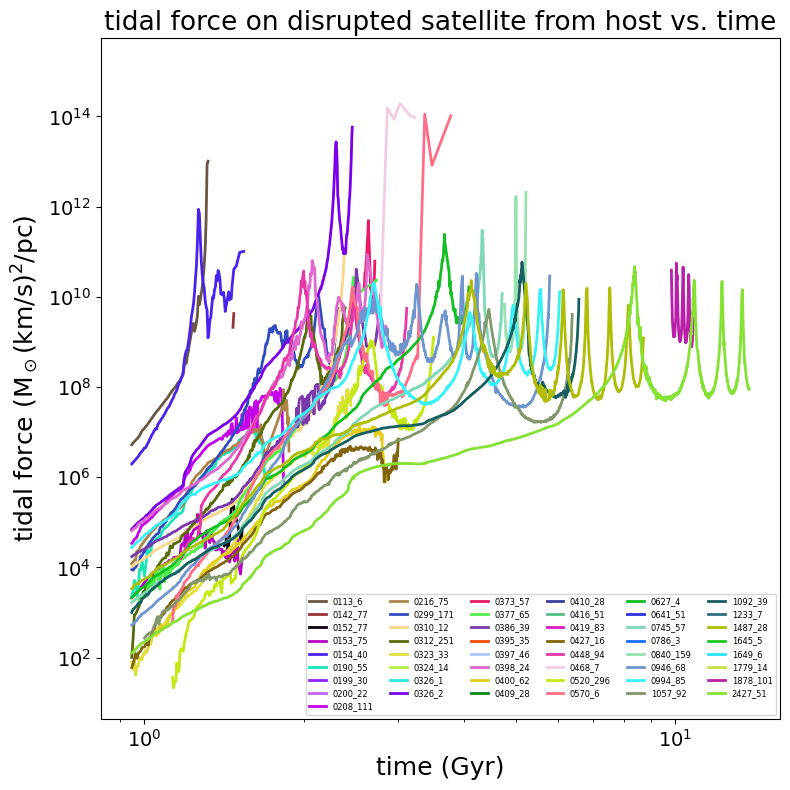

In [22]:
fig, ax = plt.subplots(figsize=(8,8))

for i in range(np.size(all_sat_t)):
    plt.plot(all_sat_t[i], all_sat_Ftide[i], linewidth=2, c=(r_array[i], b_array[i], g_array[i]), \
            label=allhosts[i])
    
plt.legend(loc='lower right', prop={'size': 6}, ncol=6)
plt.title('tidal force on disrupted satellite from host vs. time', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('tidal force (M$_\odot$(km/s)$^2$/pc)', fontsize=18)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.style.use('default')
plt.savefig('plots/disrupted_sat_tide_over_time.png')

Now, we'll make a histogram of when the stars in all of the satellites formed.

In [ ]:
import foggie.utils.foggie_load as fog
import yt
from yt import YTQuantity,YTArray
from yt.data_objects.particle_filters import add_particle_filter
import numpy as np
import h5py

In [ ]:
halo = 'Tempest'
hnum = '008508'

#Mogget
snap_name = '/Users/bnguyen/Downloads/DD2427/DD2427'
halo_c_v_name = '/Users/bnguyen/FOGGIE/foggie/halo_infos/'+hnum+'/nref11c_nref9f/halo_c_v'
trackname = '/Users/bnguyen/FOGGIE/foggie/halo_tracks/'+hnum+'/nref11n_selfshield_15/halo_track_200kpc_nref9'
masses_dir = '/Users/bnguyen/FOGGIE/foggie/halo_infos/'+hnum+'/nref11c_nref9f/'
hsfile = '/Users/bnguyen/Downloads/'+halo+'_RD0042_allhalostardata.h5'

f = h5py.File(hsfile,'r')
pids = f['particle_IDs'][:]
hids = f['host_IDs'].asstr()[:]
f.close()

def StarParts(pfilter, data):
    return data[("all", "particle_type")] == 2
    
add_particle_filter("stars", function=StarParts, filtered_type='all', requires=["particle_type"])

ds, region = fog.foggie_load(snap_name, trackname, find_halo_center=True, halo_c_v_name=halo_c_v_name, disk_relative=True, \
                            particle_type_for_angmom='young_stars', do_filter_particles=True, gravity=False,\
                            region='refine_box',masses_dir=masses_dir)
                            
ds.add_particle_filter('stars')
ads = ds.all_data()

allstarmasses = ads['stars','particle_mass']

# Create version of star allstarmasses that contains only halo stars and
# lists the masses in the same order as the halostardata file
allstarinds = ads['stars','particle_index']
index = np.argsort(allstarinds) # put particle IDs for all stars in numerical order
sorted_allstars = allstarinds[index]
sorted_index = np.searchsorted(sorted_allstars,pids)
# Create a mask that will reorder an array so that it's in the same order as the halostardata
# file and will include only halo stars
pindex = np.take(index,sorted_index,mode="clip")
mask = allstarinds[pindex] != pids
res = np.ma.array(pindex,mask=mask)
massarr = allstarmasses[np.ma.compressed(res)].in_units('Msun')
# masarr now lists the masses of the stars in the same order that the halostardata file lists their
# particle IDs, host IDs, creation times, etc

In [ ]:
all_creation_time = []
all_star_mass = []

for host_ID in allhosts:
    stars_in_this_halo = ct[hids == host_ID]
    their_respective_masses = massarr[hids == host_ID]
    all_creation_time.append(stars_in_this_halo)
    all_star_mass.append(their_respective_masses)

all_creation_time = np.array(all_creation_time, dtype='object')
all_star_mass = np.array(all_star_mass, dtype='object')

In [ ]:
halo_idx_array = np.reshape(np.arange(0, 49, 1), (7,7))

In [ ]:
print(np.shape(all_creation_time))
print(np.shape(all_star_mass))

In [ ]:
fig, ax = plt.subplots(7,7, figsize=[15, 15])

for i in range(0, 7):
    for j in range(0, 7):
        halo_idx = halo_idx_array[i, j]
        ax[i,j].hist(all_creation_time[halo_idx], color=(r_array[halo_idx], b_array[halo_idx], g_array[halo_idx]), \
                    weights=all_star_mass[halo_idx], bins=np.logspace(0,1,20))
        ax[i,j].set_xlabel('time (Gyr)')
        ax[i,j].set_xscale('log')
        ax[i,j].set_xlim(left=0.8, right=1.3e1)
        ax[i,j].tick_params(axis='y', which='major', labelsize=8)
        ax[i,j].tick_params(axis='x', which='major', labelsize=8)
        ax[i,j].minorticks_off()
        ax[i,j].set_title(allhosts[halo_idx])
    
plt.suptitle('weighted histogram of star creation time for all the disrupted halos\n', fontsize=26)
plt.tight_layout()
plt.style.use('default')
plt.savefig('plots/weighted_histogram_of_creation_time.png')

Finally, we'll try to see how many of the aforementioned halos merged over the course of universal history.

In [ ]:
# First, we check for halos with reoccurring 'consistent_trees_link' elements.
# If there is more than one of this element in the output of the .keys() function,
# that means a merger has occurred.

time_indices = []
merger_or_not = np.zeros(np.size(all_sat_t))

for i in range(np.size(all_sat_t)):
    time_idx, sat_idx = all_sat_idx[i]
    key = np.array(sim[time_idx][sat_idx].keys())    
    appearance = np.count_nonzero(key == 'consistent_trees_link')
    
    if appearance > 1:
        haloA = sim[time_idx][sat_idx]['consistent_trees_link'][0]
        haloB = sim[time_idx][sat_idx]['consistent_trees_link'][1]
        haloA_number = haloA.halo_number
        haloB_number = haloB.halo_number
        haloA_ID = haloA.finder_id
        haloB_ID = haloB.finder_id
        
        if haloA_ID < 1000 and haloB_ID < 2000: # this excludes all the phantom halos, whose IDs will be VERY large
            
            # NOTE: there'll be a "1 merging with 1" case, which is just halo finder weirdness.
            # We'll make another if statement just to exclude it before taking the time indices 
            # of actual mergers into account.
            
            if haloA_number != haloB_number:
                
                # identify mergers among the 49 satellite halos. 
                # these indices will be important for the Mvir measurements
                merger_or_not[i] = 1 
                
                time_indices.append(time_idx)
                
                print('The following halos merged:', str(haloA_number), 'with ID', str(haloA_ID), \
                  'and', str(haloB_number), 'with ID', str(haloB_ID), 'at time index', str(time_idx))
            
time_indices = np.array(time_indices)

In [ ]:
# Converting time indices into time in Gyr

time_gyr = np.zeros(np.size(time_indices))

for i in range(np.size(time_indices)):
    time_gyr[i] = sim[int(time_indices[i])].time_gyr # unit: Gyr

In [ ]:
merging_halos = all_sat_mvir[merger_or_not == 1]
halo_times = all_sat_t[merger_or_not == 1]

all_merger_mvir = np.zeros(np.size(merging_halos))

for idx in range(np.size(merging_halos)):
    merger_time = halo_times[idx]
    merger = merging_halos[idx]
    merger_mvir = merger[merger_time == time_gyr[idx]][0] # unit: Msun
    all_merger_mvir[idx] = merger_mvir

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

for i in range(int(np.size(halo_times))):
    plt.plot(time_gyr[i], all_merger_mvir[i], 'o', markersize=8, \
             c=(r_array[merger_or_not == 1][i], b_array[merger_or_not == 1][i], g_array[merger_or_not == 1][i]), \
             label=allhosts[merger_or_not == 1][i])
    
plt.legend(loc='upper right', prop={'size': 10}, ncol=2)
plt.title('virial mass of merging halos vs. merging time', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('M$_{vir}$ (M$_\odot$)', fontsize=18)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.style.use('default')
plt.savefig('plots/merger_mass_vs_time.png')

In [23]:
# NOTE: this saves the tidal force and time values of halo 51 for another analysis. see: halos_star_loss

idx_51 = np.where(allhosts == '2427_51')
Ftide_51 = all_sat_Ftide[idx_51][0] #UNIT: Msun (km/s)^2 / pc
times_51 = all_sat_t[idx_51][0] #UNIT: Gyr

with open("saved_data/tidal_force_halo51.txt", "w") as f:
    for j in range(np.size(Ftide_51)):
        f.write(str(times_51[j]) + ' ' + str(Ftide_51[j]))
        f.write('\n')
        
f.close()

print('finished!')

finished!
